In [8]:
! pip install pandas numpy matplotlib seaborn ipykernel


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
file_paths = glob.glob('dataset_020/color_dataset*.txt')
dfs = []

In [11]:
def remove_outliers(df, column_name, batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05):
    """
    Function to find and remove outliers in a DataFrame. It checks values in one column and looks for an outlier
    based on the percentage difference from the average of the batch values. If a value is more than
    the threshold percentage different from the average, it is flagged as an outlier and removed.

    :param df: A pandas DataFrame containing the dataset.
    :param column_name: The name of the column to check for outliers.
    :param batch_size: The number of rows in each batch.
    :param hop_length_ratio: The ratio of the batch size to determine the hop length for overlapping batches.
    :param threshold: The percentage difference from the average to use as a threshold for determining outliers.
    :return: The DataFrame with outliers removed and a list of row indices that were considered outliers.
    """
    outliers = []
    hop_length = int(batch_size * hop_length_ratio)  # Determine hop length based on batch size and ratio
    data_column = df[column_name].to_numpy()  # Extract the relevant column

    # Loop over the dataset in batches with the defined hop length
    for start in range(0, len(data_column), hop_length):
        end = start + batch_size
        batch = data_column[start:end]
        mean = np.mean(batch)

        # Calculate the percentage difference from the mean for each value in the batch
        percentage_diff = np.abs((batch - mean) / mean)

        # Find indices where the percentage difference is greater than the threshold
        batch_outliers = np.where(percentage_diff > threshold)[0] + start
        outliers.extend(batch_outliers)

    # Ensure that the outlier indices are within the bounds of the data array
    outliers = [index for index in outliers if index < len(data_column)]
    
    # Remove duplicate indices due to overlapping batches
    outliers = list(set(outliers))

    # Remove outliers from the DataFrame
    clean_df = df.drop(index=outliers).reset_index(drop=True)

    return clean_df, sorted(outliers)

# Example call of the function (assuming 'df' is your DataFrame and 'column_name' is the column to check)
# This will find and remove outliers in the specified column with a batch size of 5, a hop length ratio of 0.25, and a threshold of 1%
# clean_df,


In [12]:
def correct_dataset(df):
    """
    Correct the dataset based on provided rules.
    
    df: The dataframe
    
    Returns the corrected dataframe.
    """
    
    # For the start of the dataset
    first_five = df['W'].iloc[:5].diff().abs()
    first_faulty_index = first_five.idxmax()
    print(first_faulty_index)
    for idx in range(first_faulty_index):
        next_index = first_faulty_index + 1
        if next_index in df.index:  # Check if index exists in DataFrame
            for col in ['R', 'G', 'B', 'W']:
                df.at[idx, col] = int(df.loc[next_index, col])
            df.at[idx, 'control_value'] = (idx) * 0.001 + 0.001
        if (df.control_value == 0.000).any():
            zero_row = df.iloc[0].to_frame().T
            zero_row['control_value'] = 0.000
            df = pd.concat([zero_row, df]).reset_index(drop=True)
            
    
    # For the end of the dataset
    last_five = df['W'].iloc[::-1].diff().abs().iloc[:5]
    last_faulty_index = last_five.idxmax()
    
    for idx in range(last_faulty_index, len(df)):
        lower_control_value = df.loc[idx-1, 'control_value']
        if df.at[idx, 'control_value'] != lower_control_value - 0.001:
            df = df.loc[:idx-1]
            break
        
        prev_index = last_faulty_index - 1
        if prev_index in df.index:  # Check if index exists in DataFrame
            for col in ['R', 'G', 'B', 'W']:
                df.at[idx, col] = int(df.loc[prev_index, col])
            df.at[idx, 'control_value'] = (idx) * 0.001 + 0.001
    
    last_row = df.iloc[-1].to_frame().T
    last_row['control_value'] = 1.000
    df = pd.concat([df, last_row]).reset_index(drop=True)
    return df

In [13]:
test = pd.read_csv('dataset_020/color_dataset01.txt', sep=',', header=None, usecols=[1,2,3,4,5], names=["control_value", "R", "G", "B", "W"] )

In [14]:
outlier_rowsR = remove_outliers(df = test, column_name = "R", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[1]
outlier_rowsG = remove_outliers(df = test, column_name = "G", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[1]
outlier_rowsB = remove_outliers(df = test, column_name = "B", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.1)[1]
outlier_rowsW = remove_outliers(df = test, column_name = "W", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[1]
print(outlier_rowsR)
print(outlier_rowsG)
print(outlier_rowsB)
print(outlier_rowsW)

[0, 997, 998, 999]
[0, 997, 998, 999]
[0, 997, 998, 999]
[0, 997, 998, 999]


In [15]:
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=',', header=None, usecols=[1,2,3,4,5], names=["control_value", "R", "G", "B", "W"] )
    df = remove_outliers(df = df, column_name = "R", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[0]
    df = remove_outliers(df = df, column_name = "G", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[0]
    df = remove_outliers(df = df, column_name = "B", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.1)[0]
    df = remove_outliers(df = df, column_name = "W", batch_size = 100, hop_length_ratio = 0.5, threshold = 0.05)[0]
    dfs.append(df)
    
final_df = pd.concat(dfs, ignore_index=True)

In [16]:
final_df

,control_value,R,G,B,W
0,0.002,1332,896,672,2765
1,0.003,1330,894,670,2759
2,0.004,1329,893,670,2756
3,0.005,1329,892,669,2755
4,0.006,1329,892,669,2755
...,...,...,...,...,...
19955,0.995,8175,13192,13746,35797
19956,0.996,8168,13196,13758,35809
19957,0.997,8161,13201,13769,35819
19958,0.998,8160,13201,13769,35820


In [17]:
final_df.to_csv('dataset_020/color_dataset_concat.csv', index=False)

## Plot

In [18]:
dfi = final_df.reset_index()
dfi

,index,control_value,R,G,B,W
0,0,0.002,1332,896,672,2765
1,1,0.003,1330,894,670,2759
2,2,0.004,1329,893,670,2756
3,3,0.005,1329,892,669,2755
4,4,0.006,1329,892,669,2755
...,...,...,...,...,...,...
19955,19955,0.995,8175,13192,13746,35797
19956,19956,0.996,8168,13196,13758,35809
19957,19957,0.997,8161,13201,13769,35819
19958,19958,0.998,8160,13201,13769,35820


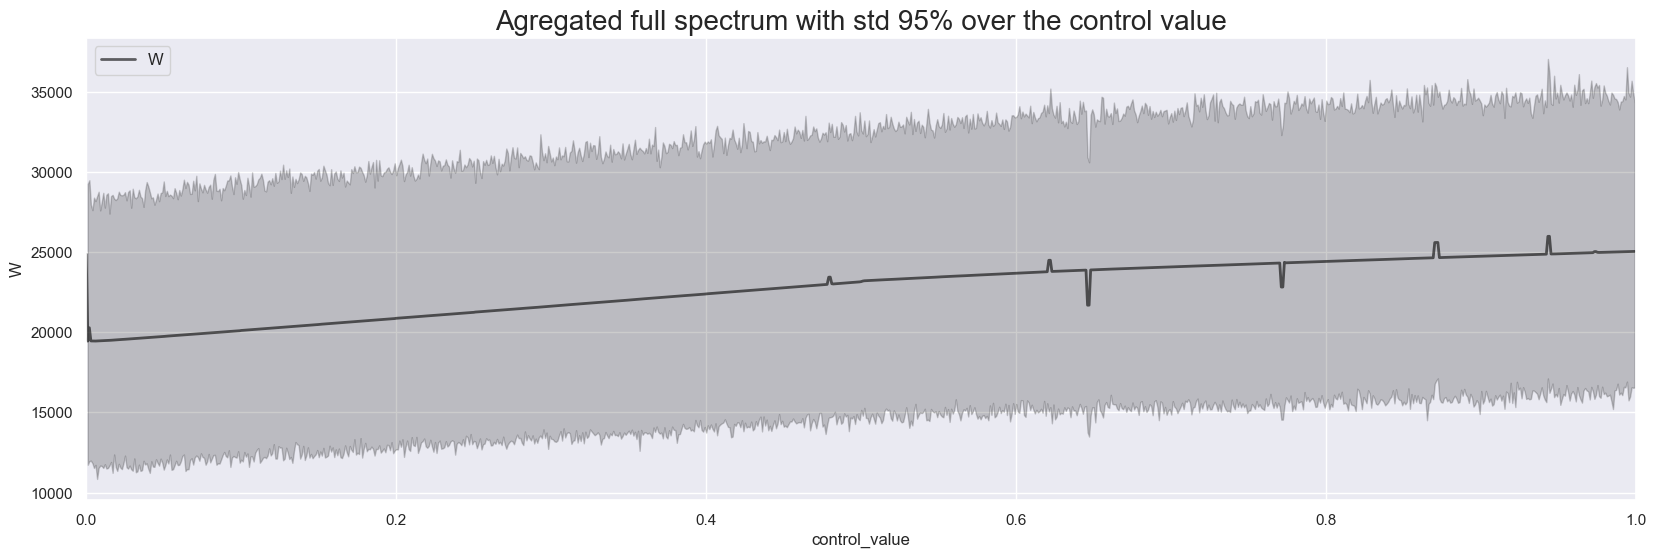

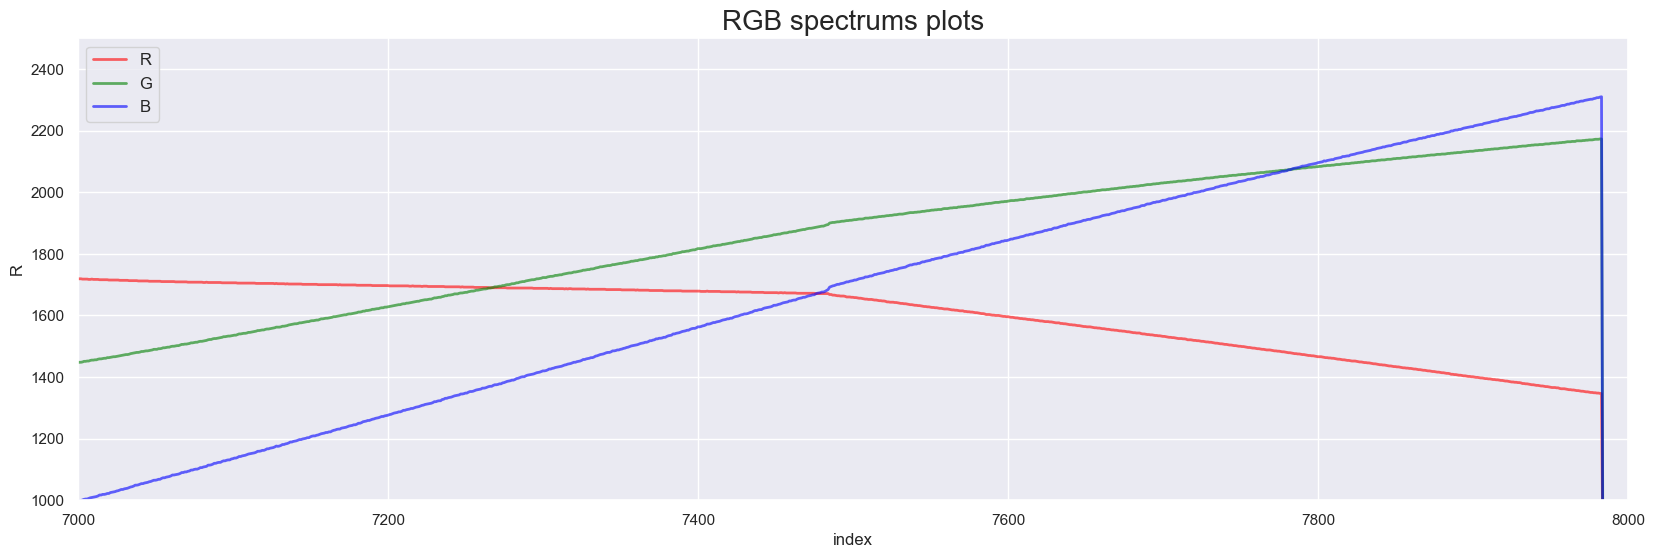

In [22]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20,6))
plt.title("Agregated full spectrum with std 95% over the control value", fontsize=20)

sns.lineplot(data=dfi, x="control_value", y="W", color="black", label="W", linewidth=2, alpha=0.6)
plt.xlim(0, 1)
plt.legend(loc='upper left', fontsize=12)
plt.show()

plt.figure(figsize=(20,6))
plt.title("RGB spectrums plots", fontsize=20)

sns.lineplot(data=dfi, x="index", y="R", color="red", label="R", linewidth=2, alpha=0.6)
sns.lineplot(data=dfi, x="index", y="G", color="green", label="G",  linewidth=2, alpha=0.6)
sns.lineplot(data=dfi, x="index", y="B", color="blue", label="B",  linewidth=2, alpha=0.6)

plt.xlim(7000, 8000)
plt.ylim(1000, 2500)
plt.legend(loc='upper left', fontsize=12)
plt.show()

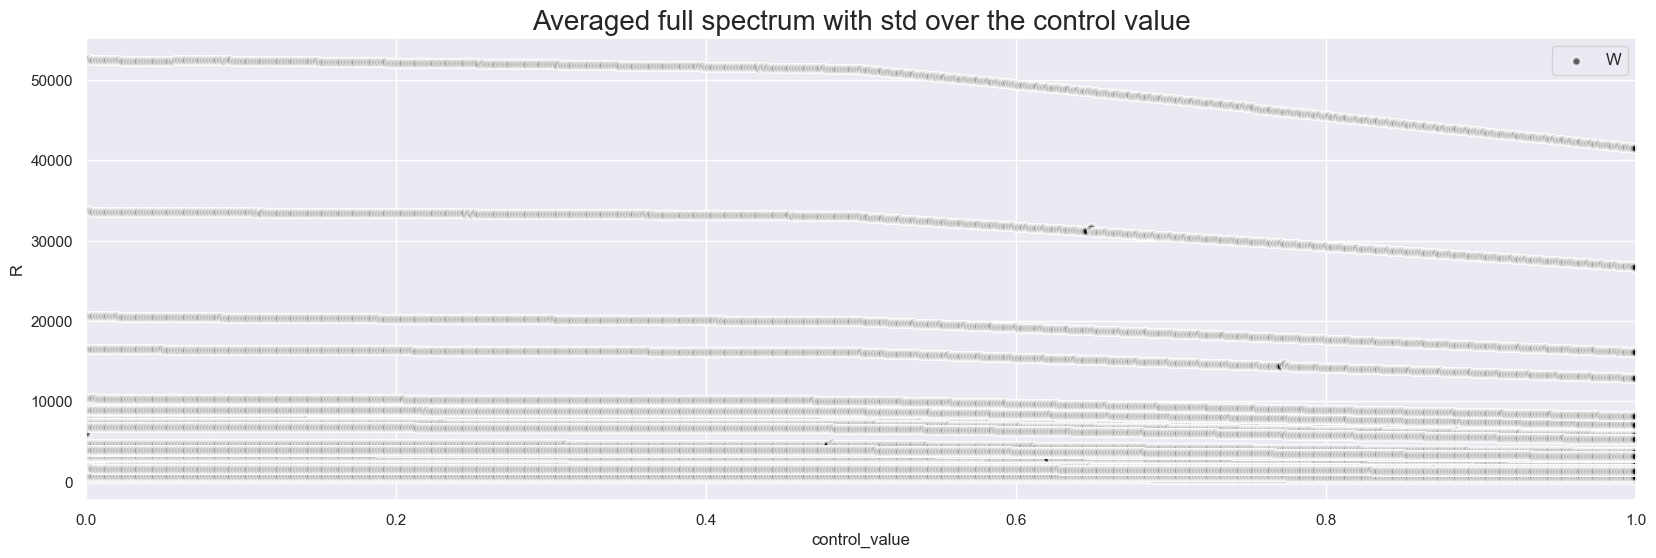

In [28]:
plt.figure(figsize=(20,6))
plt.title("Averaged full spectrum with std over the control value", fontsize=20)

sns.scatterplot(data=dfi, x="control_value", y="R", color="black", label="W", linewidth=2, alpha=0.6)
plt.xlim(0, 1)
plt.legend(loc='upper right', fontsize=12)
plt.show()

## Create Model

In [21]:
# Import the required libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the dataset
df = pd.read_csv('dataset_020/color_dataset_concat.csv')

# Split the dataset into training and testing sets
X = df[['R', 'G', 'B', 'W']]
y = df['control_value']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'dataset20_scaler.save')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[4]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.0590 - mae: 0.1921 - mse: 0.0590 - val_loss: 0.0384 - val_mae: 0.1574 - val_mse: 0.0384
Epoch 2/100
400/400 [==============================] - 0s 1ms/step - loss: 0.0225 - mae: 0.1078 - mse: 0.0225 - val_loss: 0.0151 - val_mae: 0.0787 - val_mse: 0.0151
Epoch 3/100
400/400 [==============================] - 0s 1ms/step - loss: 0.0138 - mae: 0.0806 - mse: 0.0138 - val_loss: 0.0112 - val_mae: 0.0759 - val_mse: 0.0112
Epoch 4/100
400/400 [==============================] - 0s 1ms/step - loss: 0.0102 - mae: 0.0684 - mse: 0.0102 - val_loss: 0.0072 - val_mae: 0.0486 - val_mse: 0.0072
Epoch 5/100
400/400 [==============================] - 0s 1ms/step - loss: 0.0084 - mae: 0.0608 - mse: 0.0084 - val_loss: 0.0073 - val_mae: 0.0587 - val_mse: 0.0073
Epoch 6/100
400/400 [==============================] - 0s 1ms/step - loss: 0.0074 - mae: 0.0581 - mse: 0.0074 - val_loss: 0.0075 - val_mae: 0.0556 - val_mse: 0.0075
Epoch 7/10

In [ ]:
# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

125/125 - 0s - loss: 0.0012 - mae: 0.0255 - mse: 0.0012 - 97ms/epoch - 772us/step


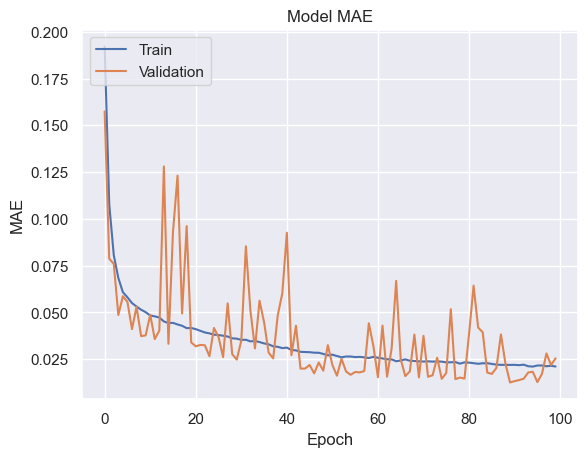

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('model_020.keras')

In [ ]:
# Use the model for prediction
predictions = model.predict(X_test)

125/125 [==============================] - 0s 629us/step


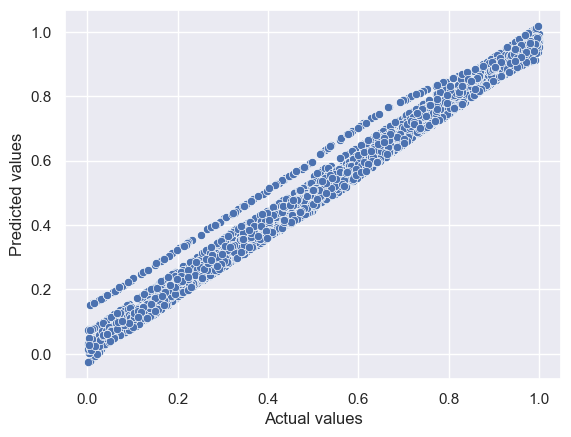

In [ ]:
# Plot the predictions against the actual values
sns.scatterplot(x=y_test, y=predictions.flatten())
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


In [ ]:
X_train.shape[1]

4

Best Prediction Errors:
Index: 1752, Absolute Error: 1.1524200439455567e-05
Index: 1528, Absolute Error: 1.9163131713906267e-05
Index: 3679, Absolute Error: 2.705168724059792e-05
Index: 3420, Absolute Error: 4.5602440834041635e-05
Index: 241, Absolute Error: 4.6910285949719466e-05
Index: 2664, Absolute Error: 5.158615112299536e-05
Index: 1578, Absolute Error: 5.219066143036244e-05
Index: 3219, Absolute Error: 7.564020156858309e-05
Index: 1695, Absolute Error: 8.529424667358398e-05
Index: 2953, Absolute Error: 8.621168136596635e-05

Worst Prediction Errors:
Index: 380, Absolute Error: 0.10612894105911252
Index: 1625, Absolute Error: 0.10640735960006714
Index: 1321, Absolute Error: 0.10642139673233031
Index: 1681, Absolute Error: 0.10642369127273554
Index: 3355, Absolute Error: 0.10656492662429806
Index: 3502, Absolute Error: 0.10658227205276494
Index: 1050, Absolute Error: 0.10660789251327518
Index: 599, Absolute Error: 0.10673310852050782
Index: 1095, Absolute Error: 0.1067912178039550

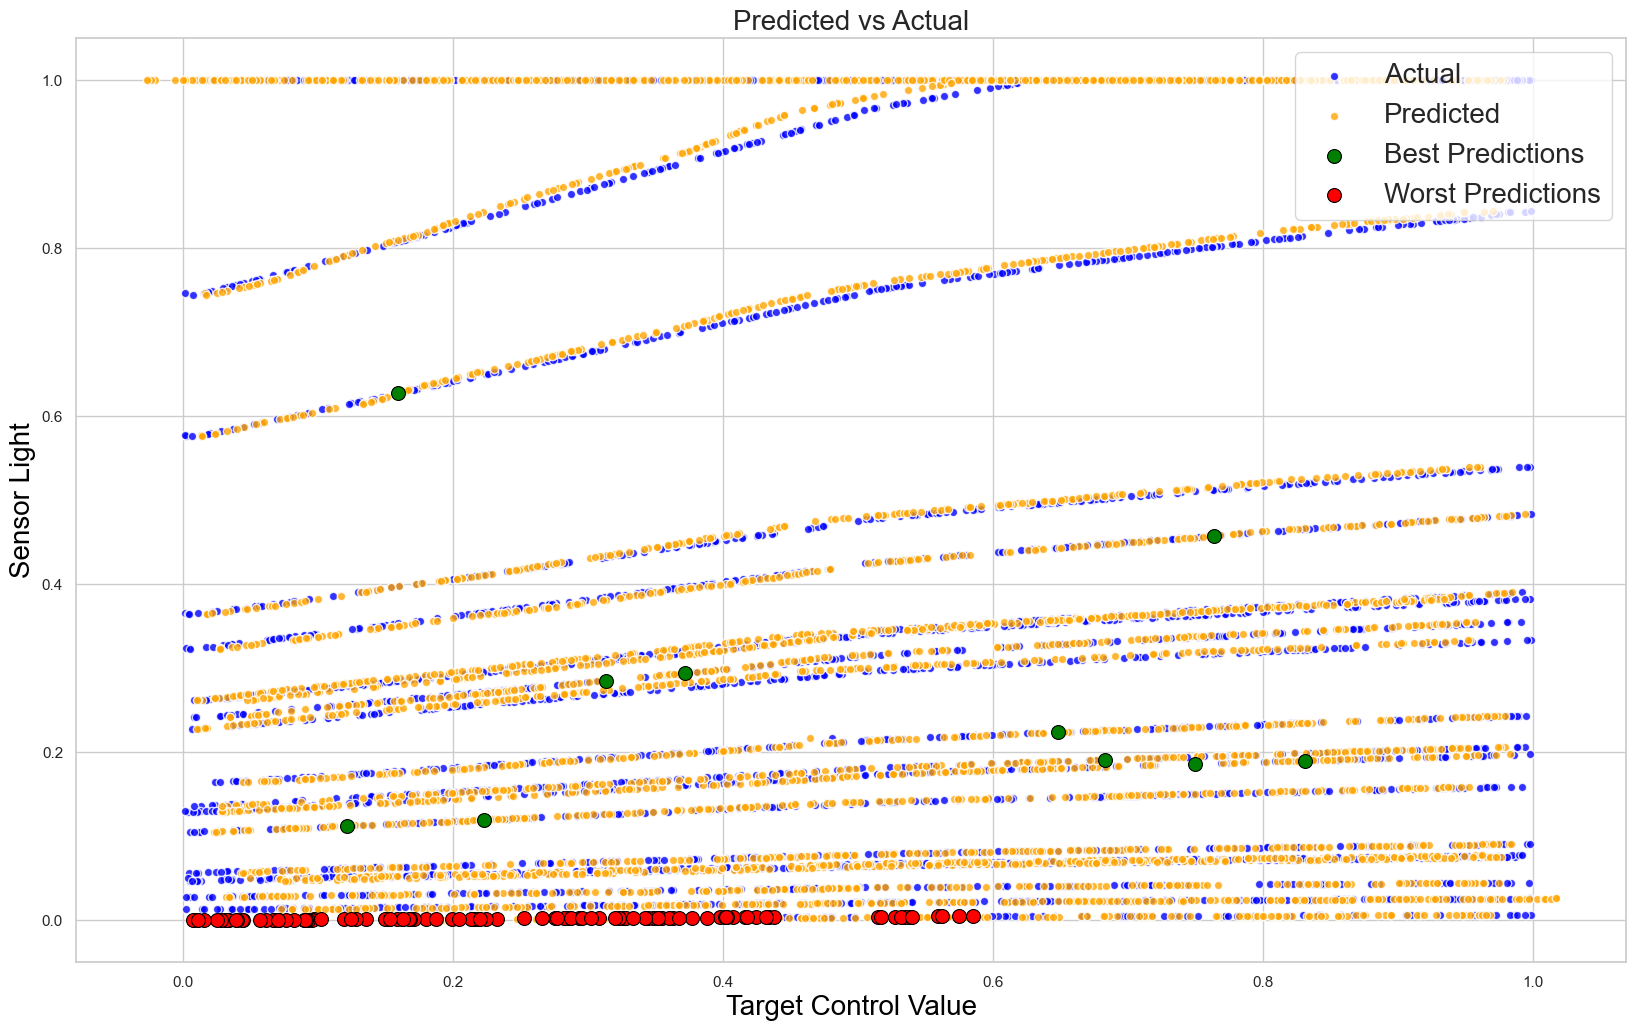

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of y_test to allow direct indexing after the train-test split
y_test = y_test.reset_index(drop=True)

# Calculate prediction errors
errors = predictions.flatten() - y_test

# Get the indices of the best and worst predictions
best_pred_indices = np.argsort(np.abs(errors))[:10]  # Indices of the 10 best predictions
worst_pred_indices = np.argsort(np.abs(errors))[-100:]  # Indices of the 10 worst predictions



absolute_errors = np.abs(errors)

best_pred_errors = absolute_errors.iloc[best_pred_indices]
worst_pred_errors = absolute_errors.iloc[worst_pred_indices]

print("Best Prediction Errors:")
for i, index in enumerate(best_pred_indices):
    print(f"Index: {index}, Absolute Error: {best_pred_errors.iloc[i]}")

print("\nWorst Prediction Errors:")
for i, index in enumerate(worst_pred_indices):
    print(f"Index: {index}, Absolute Error: {worst_pred_errors.iloc[i]}")
    



# Adjust your slicing here, if necessary
slice_min = 0
slice_max = len(y_test)  
col_slice = 3  # The feature  to plot


sns.set_style("whitegrid")
plt.figure(figsize=(20,12))
plt.title("Predicted vs Actual", fontsize=20)

sns.scatterplot(x=y_test[slice_min:slice_max], y=X_test[slice_min:slice_max, col_slice], color="blue", label="Actual", linewidth=1, alpha=0.8)
sns.scatterplot(x=predictions.flatten()[slice_min:slice_max], y=X_test[slice_min:slice_max, col_slice], color="orange", label="Predicted", linewidth=1, alpha=0.8)

# Highlight the best predictions
sns.scatterplot(x=y_test[best_pred_indices], y=X_test[best_pred_indices, col_slice], color="green", label="Best Predictions", s=100, edgecolor='black')

# Highlight the worst predictions
sns.scatterplot(x=y_test[worst_pred_indices], y=X_test[worst_pred_indices, col_slice], color="red", label="Worst Predictions", s=100, edgecolor='black')


plt.xlabel('Target Control Value', color='black', fontsize=20)
plt.ylabel('Sensor Light', color='black', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.show()
